In [257]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from math import floor
from matplotlib.ticker import MaxNLocator
import calendar
import geopandas as gpd
from shapely.geometry import Point
import folium
from folium.plugins import FloatImage

df = pd.read_csv("Crime_Data_from_2020_to_Present.csv")
df.head(3)

DR_NO               Date Rptd                DATE OCC  TIME OCC  AREA  \
0  190326475  03/01/2020 12:00:00 AM  03/01/2020 12:00:00 AM      2130     7   
1  200106753  02/09/2020 12:00:00 AM  02/08/2020 12:00:00 AM      1800     1   
2  200320258  11/11/2020 12:00:00 AM  11/04/2020 12:00:00 AM      1700     3   

   AREA NAME  Rpt Dist No  Part 1-2  Crm Cd            Crm Cd Desc  ...  \
0   Wilshire          784         1     510       VEHICLE - STOLEN  ...   
1    Central          182         1     330  BURGLARY FROM VEHICLE  ...   
2  Southwest          356         1     480          BIKE - STOLEN  ...   

  Status   Status Desc Crm Cd 1 Crm Cd 2  Crm Cd 3 Crm Cd 4  \
0     AA  Adult Arrest    510.0    998.0       NaN      NaN   
1     IC   Invest Cont    330.0    998.0       NaN      NaN   
2     IC   Invest Cont    480.0      NaN       NaN      NaN   

                                  LOCATION Cross Street      LAT       LON  
0  1900 S  LONGWOOD                     AV          NaN  34.0375 -118.3506  
1  1000 S  FLOWER                       ST          NaN  34.0444 -118.2628  
2  1400 W  37TH                         ST          NaN  34.0210 -118.3002  

[3 rows x 28 columns]

El dataset contiene información de crímenes de Los Ángeles desde el año 2020 al presente. La descripción del sitio se traduce en:
"Este conjunto de datos refleja incidentes de crimen en la ciudad de Los Ángeles que se remontan hasta 2020. Estos datos se transcriben de informes de crimen originales que se escriben en papel, por lo tanto, puede haber algunas inexactitudes dentro de los datos. Algunos campos de ubicación con datos faltantes se anotan como (0°, 0°). Los campos de dirección solo se proporcionan hasta la cuadra más cercana para mantener la privacidad."

Las columnas, en orden, representan:
- DR_NO: ID del reporte.
- Date Rptd: Fecha reportado.
- DATE OCC: Fecha ocurrido.
- TIME OCC: Hora y minuto del hecho.
- AREA: ID del área
- AREA NAME: Nombre del área.
- Rpt Dist No: Código de subárea dentro del área
- Part 1-2: Los crímenes en EEUU se clasifican en Parte 1 y Parte 2 según severidad, siendo los crímenes Parte 1 considerados más graves.
- Crm Cd: Código del crimen.
- Crm Cd Desc: Descripción del crimen.
- Mocodes: Código del Modus Operandi del crimen.
- Vict Age: Edad de la víctima.
- Vict Sex: Seco de la víctima.
- Vict Descent: Etnia de la víctima.
- Premis Cd: ID de la estructura, vehículo o lugar donde ocurrió el crimen.
- Premis Desc: Descripción de la estructura, vehículo o lugar donde ocurrió el crimen.
- Weapon Used Cd: ID del arma utilizada
- Weapon Desc: Descripción del arma utilizada
- Status: Código del estado actual de la investigación/juicio.
- Status Desc: Descripción del estado.
- Crm Cd 1, Crm Cd 2, Crm Cd 3, Crm Cd 4: Códigos adicionales para describir el crimen.
- LOCATION: Dirección del hecho aproximada.
- Cross Street: La intersección donde ocurrió el crimen.
- LAT: Latitud.
- LONG: Longitud



In [258]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 938457 entries, 0 to 938456
Data columns (total 28 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DR_NO           938457 non-null  int64  
 1   Date Rptd       938457 non-null  object 
 2   DATE OCC        938457 non-null  object 
 3   TIME OCC        938457 non-null  int64  
 4   AREA            938457 non-null  int64  
 5   AREA NAME       938457 non-null  object 
 6   Rpt Dist No     938457 non-null  int64  
 7   Part 1-2        938457 non-null  int64  
 8   Crm Cd          938457 non-null  int64  
 9   Crm Cd Desc     938457 non-null  object 
 10  Mocodes         806568 non-null  object 
 11  Vict Age        938457 non-null  int64  
 12  Vict Sex        813003 non-null  object 
 13  Vict Descent    812993 non-null  object 
 14  Premis Cd       938447 non-null  float64
 15  Premis Desc     937894 non-null  object 
 16  Weapon Used Cd  323066 non-null  float64
 17  Weapon Des

# Limpieza de datos

Dropeamos las columnas que no nos serán de interés.
Droppearemos las columnas:
- DR_NO: No aporta información útil.
- Date Rptd: Solo interesa la fecha de ocurrencia.
- Crm Cd: Nos basta con tener la descripción del crimen para entender su naturaleza, de hecho, nos es más representativo.
- Crm Cd 1-4:  Idem.
- Mocodes: Puede tener varios en un mismo Modus Operandi, y complejiza el análisis exploratorio.
- Premis Cd: Nos basta con la descripción de las Premisas.
- Weapon Used Cd: Nos basta con la infomación del arma.
- Status: Status Desc da mayor información sobre el estado.
- Cross Street: No aporta información útil para un análisis exploratorio
- AREA: Nos quedamos simplemente con el nombre del área
- LOCATION: Nos guíamos por la latitud y la longitud, y el área.
- Rpt Dist No: No interesa para el análisis, pues no tiene ningún propósito conocer el nombre del distrito dentro del área.

In [259]:
df_limpio = df
# Variables con muchos valores faltantes o que no aportan información de interés.
df_limpio = df.drop(["Crm Cd 1", "Crm Cd 2", "Crm Cd 3", "Crm Cd 4", "DR_NO", "Mocodes", "Cross Street", "Rpt Dist No"], axis=1)
# Variables que tienen una equivalencia en string
df_limpio = df_limpio.drop(["AREA", "Crm Cd", "Premis Cd", "Weapon Used Cd", "Status"], axis=1)
# Para esta arista del análisis, preferimos la latitud y longitud
df_limpio = df_limpio.drop(["LOCATION"], axis=1)
df_limpio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 938457 entries, 0 to 938456
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Date Rptd     938457 non-null  object 
 1   DATE OCC      938457 non-null  object 
 2   TIME OCC      938457 non-null  int64  
 3   AREA NAME     938457 non-null  object 
 4   Part 1-2      938457 non-null  int64  
 5   Crm Cd Desc   938457 non-null  object 
 6   Vict Age      938457 non-null  int64  
 7   Vict Sex      813003 non-null  object 
 8   Vict Descent  812993 non-null  object 
 9   Premis Desc   937894 non-null  object 
 10  Weapon Desc   323066 non-null  object 
 11  Status Desc   938457 non-null  object 
 12  LAT           938457 non-null  float64
 13  LON           938457 non-null  float64
dtypes: float64(2), int64(3), object(9)
memory usage: 100.2+ MB


Le damos el formato deseado a las columnas que representan tiempo

In [260]:
# Como la parte de la fecha ocupa solo los primeros 10 caracteres, nos quedamos con ellos
df_limpio = df_limpio.drop(columns=["Date Rptd"])
df_limpio["DATE OCC"] = df_limpio["DATE OCC"].str.slice(0, 10)
df_limpio.head(10)


DATE OCC  TIME OCC  AREA NAME  Part 1-2  \
0  03/01/2020      2130   Wilshire         1   
1  02/08/2020      1800    Central         1   
2  11/04/2020      1700  Southwest         1   
3  03/10/2020      2037   Van Nuys         1   
4  08/17/2020      1200  Hollywood         2   
5  12/01/2020      2300  Southeast         2   
6  07/03/2020       900    Central         2   
7  05/12/2020      1110  Southwest         2   
8  12/09/2020      1400     Newton         2   
9  12/31/2020      1220    Mission         2   

                                Crm Cd Desc  Vict Age Vict Sex Vict Descent  \
0                          VEHICLE - STOLEN         0        M            O   
1                     BURGLARY FROM VEHICLE        47        M            O   
2                             BIKE - STOLEN        19        X            X   
3  SHOPLIFTING-GRAND THEFT ($950.01 & OVER)        19        M            O   
4                         THEFT OF IDENTITY        28        M            H   
5                         THEFT OF IDENTITY        41        M            H   
6                         THEFT OF IDENTITY        25        M            H   
7                         THEFT OF IDENTITY        27        F            B   
8                         THEFT OF IDENTITY        24        F            B   
9                  BATTERY - SIMPLE ASSAULT        26        M            H   

                                    Premis Desc  \
0                                        STREET   
1             BUS STOP/LAYOVER (ALSO QUERY 124)   
2  MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)   
3                                CLOTHING STORE   
4                                      SIDEWALK   
5                        SINGLE FAMILY DWELLING   
6  MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)   
7                              CELL PHONE STORE   
8                                    CYBERSPACE   
9  MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)   

                                      Weapon Desc   Status Desc      LAT  \
0                                             NaN  Adult Arrest  34.0375   
1                                             NaN   Invest Cont  34.0444   
2                                             NaN   Invest Cont  34.0210   
3                                             NaN   Invest Cont  34.1576   
4                                             NaN   Invest Cont  34.0944   
5                                             NaN   Invest Cont  33.9467   
6                                             NaN   Invest Cont  34.0415   
7                                             NaN   Invest Cont  34.0335   
8                                             NaN   Invest Cont  33.9911   
9  STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)   Invest Cont  34.2336   

        LON  
0 -118.3506  
1 -118.2628  
2 -118.3002  
3 -118.4387  
4 -118.3277  
5 -118.2463  
6 -118.2620  
7 -118.3537  
8 -118.2521  
9 -118.4535

## Estandarizando datos desconocidos/faltantes

Para las variables cualitativas, reemplazamos los valores faltantes por "Desconocido/NA", para las cuantitativas, por nan.

In [261]:
# Necesitamos la hora del hecho en el formato correcto
# El 1 simboliza que no se tiene el dato, lo reemplazamos por la observación inmediatamente superior
# para que no altere luego los patrones en los datos.
df_limpio["TIME OCC"] = df_limpio["TIME OCC"].astype("int")
df_limpio["TIME OCC"] = df_limpio["TIME OCC"].fillna(method='pad')
df_limpio["TIME OCC"] = df_limpio["TIME OCC"].apply(lambda x: floor(x / 100))

In [262]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 938457 entries, 0 to 938456
Data columns (total 28 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DR_NO           938457 non-null  int64  
 1   Date Rptd       938457 non-null  object 
 2   DATE OCC        938457 non-null  object 
 3   TIME OCC        938457 non-null  int64  
 4   AREA            938457 non-null  int64  
 5   AREA NAME       938457 non-null  object 
 6   Rpt Dist No     938457 non-null  int64  
 7   Part 1-2        938457 non-null  int64  
 8   Crm Cd          938457 non-null  int64  
 9   Crm Cd Desc     938457 non-null  object 
 10  Mocodes         806568 non-null  object 
 11  Vict Age        938457 non-null  int64  
 12  Vict Sex        813003 non-null  object 
 13  Vict Descent    812993 non-null  object 
 14  Premis Cd       938447 non-null  float64
 15  Premis Desc     937894 non-null  object 
 16  Weapon Used Cd  323066 non-null  float64
 17  Weapon Des

### Vict age

In [263]:
df_limpio["Vict Age"].describe()

count    938457.000000
mean         29.520231
std          21.875415
min          -4.000000
25%           0.000000
50%          30.000000
75%          45.000000
max         120.000000
Name: Vict Age, dtype: float64

El primer cuartil es 0, lo cual indica que existen más de 25% de datos faltantes, los reemplazamos por pd.nan para que luego no interfieran en el análisis. Además, existen personas con edad negativa.

In [264]:
len(df_limpio[df_limpio["Vict Age"] <= 0])/len(df_limpio)

0.2539114738341767

In [265]:
df_limpio['Vict Age'] = df_limpio['Vict Age'].where(df_limpio['Vict Age'] > 0, np.nan)
# Además, hay una persona que figura con edad 120, lo cual solo puede ser un error.
df_limpio['Vict Age'] = df_limpio['Vict Age'].where(df_limpio['Vict Age'] != 120, np.nan)
# Comprobamos que no haya ningún error más
df_limpio["Vict Age"].describe()

count    700171.000000
mean         39.566777
std          15.615966
min           2.000000
25%          28.000000
50%          37.000000
75%          50.000000
max          99.000000
Name: Vict Age, dtype: float64

### Pasando fechas a pd.datetime

In [266]:
df_limpio["DATE OCC"] = pd.to_datetime(df_limpio["DATE OCC"], format="%m/%d/%Y")

Latitudes y longitudes

In [267]:
# Queremos que el (0°, 0°) refleje mejor que faltan los datos
df_limpio["LAT"] = df_limpio["LAT"].replace(0, np.nan).astype("float")
df_limpio["LON"] = df_limpio["LON"].replace(0, np.nan).astype("float")
df_limpio["LON"].head(10)

0   -118.3506
1   -118.2628
2   -118.3002
3   -118.4387
4   -118.3277
5   -118.2463
6   -118.2620
7   -118.3537
8   -118.2521
9   -118.4535
Name: LON, dtype: float64

Comprobamos que no existan categorías incorrectas en las principales variables cualitativas


In [268]:
print(df_limpio["Part 1-2"].unique())
print(df_limpio["Vict Sex"].unique())
print(df_limpio["Vict Descent"].unique())

[1 2]
['M' 'X' 'F' nan 'H' '-']
['O' 'X' 'H' 'B' 'W' nan 'A' 'C' 'K' 'J' 'F' 'I' 'V' 'S' 'P' 'Z' 'G' 'U'
 'D' 'L' '-']


In [269]:
# Unificamos todos en NA, para luego facilitar la manipulación
df_limpio["Vict Sex"] = df_limpio["Vict Sex"].replace(["-", "H", np.nan, "X"], "Desconocido/NA")
df_limpio["Vict Descent"] = df_limpio["Vict Descent"].replace([np.nan, "-"], "Desconocido/NA")

Cambiamos el nombre y los valores de la columna para mayor claridad

In [270]:
df_limpio["Part 1-2"] = df_limpio["Part 1-2"].replace(1, "Severe")
df_limpio["Part 1-2"] = df_limpio["Part 1-2"].replace(2, "Mild")
origenes = dict()
origenes["A"] = "Asian" # Other asians
origenes["Z"] = "Asian" # Indian
origenes["C"] = "Asian" # Chinese
origenes["F"] = "Asian" # Filipino
origenes["D"] = "Asian" # Camboyano
origenes["G"] = "Asian" # Guamanian, de Guam
origenes["J"] = "Asian" # Japanese
origenes["K"] = "Asian" # Korean
origenes["L"] = "Asian" # Laotian
origenes["V"] = "Asian" # Vietnamese
origenes["P"] = "Oceanic" # Pacific islander
origenes["S"] = "Oceanic" # Samoan
origenes["U"] = "Oceanic" # Hawaiian
origenes["I"] = "Indigenous" # American Indian / Alaskan native
origenes["H"] = "Hispanic"
origenes["W"] = "White"
origenes["O"] = "Other"
origenes["B"] = "Black"
origenes["X"] = "Desconocido/NA"
for key, value in origenes.items():
    df_limpio["Vict Descent"] = df_limpio["Vict Descent"].replace(key, value)

### Agrupando categorías

Vemos que la mayorìa de variables categóricas tienen un número muy elevado de categorías distintas y muy específicas, por lo que las agrupamos para hacer las categorías más generales.

In [271]:
df_limpio.info()
# Printeamos el resto de variables categoricas para saber si hay que hacer más limpieza
print(df_limpio["Crm Cd Desc"].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 938457 entries, 0 to 938456
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   DATE OCC      938457 non-null  datetime64[ns]
 1   TIME OCC      938457 non-null  int64         
 2   AREA NAME     938457 non-null  object        
 3   Part 1-2      938457 non-null  object        
 4   Crm Cd Desc   938457 non-null  object        
 5   Vict Age      700171 non-null  float64       
 6   Vict Sex      938457 non-null  object        
 7   Vict Descent  938457 non-null  object        
 8   Premis Desc   937894 non-null  object        
 9   Weapon Desc   323066 non-null  object        
 10  Status Desc   938457 non-null  object        
 11  LAT           936193 non-null  float64       
 12  LON           936193 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(8)
memory usage: 93.1+ MB
['VEHICLE - STOLEN' 'BURGLARY FROM VEHICLE

In [272]:
# Con la ayuda de ChatGPT,
# categorizamos crímenes segun palabras clave usando expresiones regulares
def categorize_crime(crime):
    if pd.isnull(crime):
        return 'Desconocido/NA'
    elif re.search('STOLEN|BURGLARY|ROBBERY|THEFT|PICKPOCKET|STEAL|SHOPLIFTING|SNATCHING|TILL', crime):
        return 'Theft/Burglary'
    elif re.search('ASSAULT|BATTERY', crime):
        return 'Assault/Battery'
    elif re.search('SEX|SODOMY|RAPE|EXPOSURE|PENETRATION|LEWD|PORNOGRAPHY|COPULATION', crime):
        return 'Sexual Crimes'
    elif re.search('FRAUD|EMBEZZLEMENT|BIGAMY|FORGERY|COUNTERFEIT|FALSIFICATION|UNAUTHORIZED|BRIBERY|DOCUMENT|BUNCO', crime):
        return 'Fraud/Financial Crimes'
    elif re.search('VANDALISM|ARSON|FIRE', crime):
        return 'Vandalism/Arson'
    elif re.search('KIDNAPPING|ABDUCTION|HUMAN TRAFFICKING|PIMPING', crime):
        return 'Kidnapping'
    elif re.search('HOMICIDE|MURDER|MANSLAUGHTER', crime):
        return 'Homicide'
    elif re.search('WEAPON|FIREARM|GUN|BOMB', crime):
        return 'Weapon Crimes'
    elif re.search('STALKING|PEEPING TOM|RESTRAINING ORDER|THREAT|TRESPASSING', crime):
        return 'Harrassment'
    elif re.search('RESISTING|LYNCH|YIELD|CONSPIRACY|RIOT|TRAIN WRECKING|DISPERSE|BLOCKING|DISRUPT|DISTURB|RECKLESS', crime):
        return 'Public Order Crimes'
    else:
        return "Other"

# Aplicamos la función a la columna de interés
df_limpio['Crm Cd Desc'] = df_limpio['Crm Cd Desc'].apply(categorize_crime)

In [273]:
print(df_limpio["AREA NAME"].unique())
print(df_limpio["Status Desc"].unique())
print(df_limpio["Premis Desc"].unique())
print(df_limpio["Weapon Desc"].unique())

['Wilshire' 'Central' 'Southwest' 'Van Nuys' 'Hollywood' 'Southeast'
 'Newton' 'Mission' 'Rampart' 'West Valley' 'West LA' 'Olympic'
 'Hollenbeck' 'Topanga' 'Northeast' '77th Street' 'Pacific' 'N Hollywood'
 'Harbor' 'Foothill' 'Devonshire']
['Adult Arrest' 'Invest Cont' 'Juv Arrest' 'Adult Other' 'Juv Other' 'UNK']
['STREET' 'BUS STOP/LAYOVER (ALSO QUERY 124)'
 'MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)' 'CLOTHING STORE'
 'SIDEWALK' 'SINGLE FAMILY DWELLING' 'CELL PHONE STORE' 'CYBERSPACE'
 'WEBSITE' 'OTHER BUSINESS' 'PARKING LOT' 'OTHER RESIDENCE'
 'AUTOMATED TELLER MACHINE (ATM)' 'DEPARTMENT STORE' 'PUBLIC STORAGE'
 'GARAGE/CARPORT' 'EQUIPMENT RENTAL' 'OFFICE BUILDING/OFFICE'
 'POLICE FACILITY' 'MTA BUS' 'SPECIALTY SCHOOL/OTHER' 'BANK'
 'GOVERNMENT FACILITY (FEDERAL,STATE, COUNTY & CITY)' 'SKATING RINK*'
 'BUS STOP' 'JUNIOR HIGH SCHOOL' 'OTHER/OUTSIDE' 'ALLEY'
 'VEHICLE, PASSENGER/TRUCK' 'ABANDONED BUILDING ABANDONED HOUSE'
 'TRANSPORTATION FACILITY (AIRPORT)' 'MOTEL' 'HOSPITAL'
 

In [274]:
def categorize_location(location):
    if pd.isnull(location):
        return 'Desconocido/NA'
    elif re.search('STREET|FREEWAY|APARTMENT|HOUSING|BRIDGE|TUNNEL|BUILDING|ALLEY|DUMPSTER|STAIRCASE|DWELLING|RESIDENCE|CONDOMINIUM|TOWNHOUSE|RESIDENTIAL|HOME|HOUSE', location):
        return 'Residential Areas'
    elif re.search('MOTEL|SALON|PARKING|TATTOO|PARLOR|WASH|SALES|COMPANY|MART|SHOP|STORE|STUDIO|BUSINESS|RENTAL|DEPARTMENT|OFFICE|ATM|BANK|SALES LOT|MARKET|MALL|AUTO DEALERSHIP', location):
        return 'Commercial Areas'
    elif re.search('BUS|MTA|TRANSPORTATION|TAXI|TRAIN|METRO', location):
        return 'Public Transport'
    elif re.search('SCHOOL|DAYCARE|UNIVERSITY|COLLEGE', location):
        return 'Educational Institutions'
    elif re.search('HOSPITAL|HOSPICE|CLINIC|CARE|NURSING|CONVALESCENT|RETIREMENT|MEDICAL|DENTAL|VETERINARIAN', location):
        return 'Healthcare Facilities'
    elif re.search('COLISEUM|GAME|COURT|STADIUM|SPORT|HOCKEY|MOVIE|SPORTS|GOLF|CLUB|SPA|GYM|PARK|PLAYGROUND|SKATING|BEACH|SKATEBOARD|CONVENTION|MUSEUM|POOL', location):
        return 'Recreational Areas'
    elif re.search('RESTAURANT|BAR|CATERING|COFFEE|FOOD|PATIO', location):
        return 'Food and Beverage Places'
    elif re.search('CHURCH|CHAPEL|MASS|TEMPLE|WORSHIP|MOSQUE', location):
        return 'Religious Institutions'
    elif re.search('GOVERNMENT|POLICE|JAIL|MAIL|MONUMENT|SHELTER|POST OFFICE|FIRE STATION|LIBRARY|DAM', location):
        return 'Government Facilities'
    elif re.search('STORAGE|CLEANER|REFINERY|PLANT|FACTORY|FACILITY|CONSTRUCTION|MANUFACTURER', location):
        return 'Industrial Facilities'
    else:
        return "Other"

df_limpio['Premis Desc'] = df_limpio['Premis Desc'].apply(categorize_location)

In [275]:
def categorize_weapon(weapon):
    if pd.isnull(weapon):
        return 'Desconocido/NA'
    elif re.search('GUN|FIREARM|RIFLE|REVOLVER|PISTOL|ASSAULT', weapon):
        return 'Firearms'
    elif re.search('VERBAL', weapon):
        return 'Verbal'
    elif re.search('KNIFE|BLADE|AXE|RAZOR|SCISSORS|PICK|SWORD|DAGGER|CUTTING|MACHETE|CLEAVER|GLASS|ARROW|SCREWDRIVER', weapon, re.IGNORECASE):
        return 'Bladed Weapons'
    elif re.search('HANDS|FIST|FEET|BODILY FORCE|PHYSICAL PRESENCE', weapon):
        return 'Bodily Force'
    elif re.search('VEHICLE', weapon):
        return 'Vehicles'
    elif re.search('BOMB|EXPLOSIVE', weapon):
        return 'Explosives'
    elif re.search('CLUB|BAT|STICK|PIPE|CHAIN|HAMMER|BLUNT|BOTTLE|BRICK|ROCK|KNUCKLES', weapon):
        return 'Blunt Instruments'
    else:
        return "Other"

df_limpio['Weapon Desc'] = df_limpio['Weapon Desc'].apply(categorize_weapon)

Vemos que Weapon Desc tiene nan's y Status Desc tiene "UNK"


In [276]:
df_limpio["Weapon Desc"] = df_limpio["Weapon Desc"].replace(np.nan, "Desconocido/NA")
df_limpio["Status Desc"] = df_limpio["Status Desc"].replace("UNK", "Desconocido/NA")

## Renombramos columnas

Renombramos columnas para darles nombres más claros, significativos y estándar.

In [277]:
df_limpio.rename(columns={"AREA NAME": "Area Name", "Crm Cd Desc": "Crime", \
                          "Premis Desc":"Crime Context", \
                          "Vict Descent":"Vict Origin", "Part 1-2":"Severity", \
                          "Status Desc":"Investigation Status", \
                          "Weapon Desc":"Weapon", "DATE OCC": "Date Occ",\
                          "TIME OCC": "Time Occ"}, inplace=True)

In [278]:
df = df_limpio

# Análisis exploratorio

## Variables cualitativas

### Crime

<ipython-input-279-f8eb9991253c>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(conteo_crimenes.index, rotation=90)


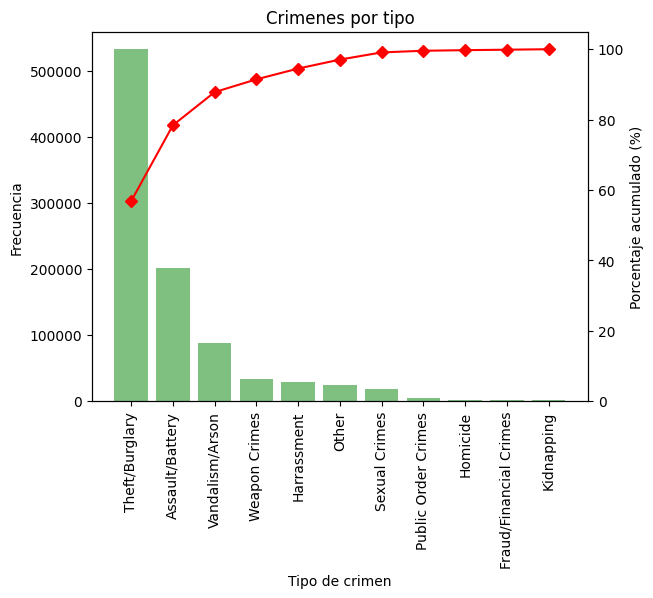

In [279]:
conteo_crimenes = df["Crime"].value_counts()
acum = (conteo_crimenes.cumsum() / conteo_crimenes.sum()) * 100

fig, ax1 = plt.subplots()
ax1.bar(conteo_crimenes.index, conteo_crimenes, color='g', alpha=0.5)
ax1.set_xticklabels(conteo_crimenes.index, rotation=90)


ax2 = ax1.twinx()
ax2.plot(conteo_crimenes.index, acum, color='r', marker='D')
ax2.set_ylim(0,105)

ax1.set_xlabel('Tipo de crimen')
ax1.set_ylabel('Cantidad')
ax2.set_ylabel('Porcentaje acumulado (%)')
ax1.set_title('Crimenes por tipo')
ax1.set_ylabel('Frecuencia')
ax2.set_ylabel('Porcentaje acumulado (%)')

plt.show()

Vemos que el tipo más común de crimen es el robo o el hurto, que representan más de la mitad del total. Además, entre robos, agresiones y vandalismo representan más del 85% de los crímenes reportados, mientras que crímenes como el acoso, los homicidios y las agresiones sexuales son mucho menos comunes.

### Weapon

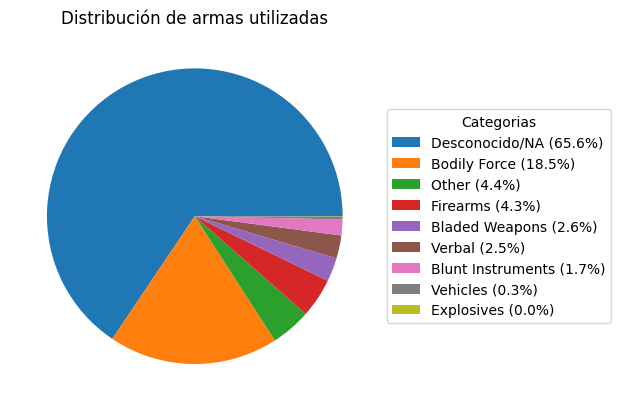

In [280]:
recuento_prop = df["Weapon"].value_counts()/len(df["Weapon"])

categorias = [f'{valor} ({recuento_prop.loc[valor]*100:.1f}%)' for valor in recuento_prop.index]
valores = recuento_prop.iloc[0:]

# Crear el gráfico de pastel
fig, ax = plt.subplots()
ax.pie(valores, labels=None)

ax.legend(categorias,
          title="Categorias",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))


plt.title("Distribución de armas utilizadas")
plt.show()

Vemos que en la gran mayoría de crímenes no se registra ningún arma en la comisión del crimen, siendo esta categoría la moda. Puede resultar interesante analizar los casos en que sí se conoce el arma del crimen.


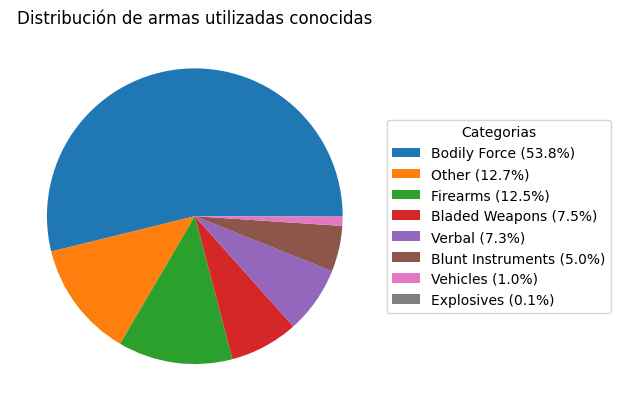

In [281]:
armas_conocidas = df[df["Weapon"] != "Desconocido/NA"]["Weapon"]
recuento = armas_conocidas.value_counts()/len(armas_conocidas)

categorias = [f'{valor} ({recuento.loc[valor]*100:.1f}%)' for valor in recuento.index]
valores = recuento.iloc[0:]

fig, ax = plt.subplots()
ax.pie(valores, labels=None)

ax.legend(categorias,
          title="Categorias",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.title("Distribución de armas utilizadas conocidas")
plt.show()

Los crímenes en los que se reporta un arma son cometidos en más de la mitad de los casos con las manos desnudas, llegando a más del 61% si se incluyen los ataques verbales. Del 38.9% restante, se incluye una gran proporción de armas de fuego, punzantes y contundentes.

### Context

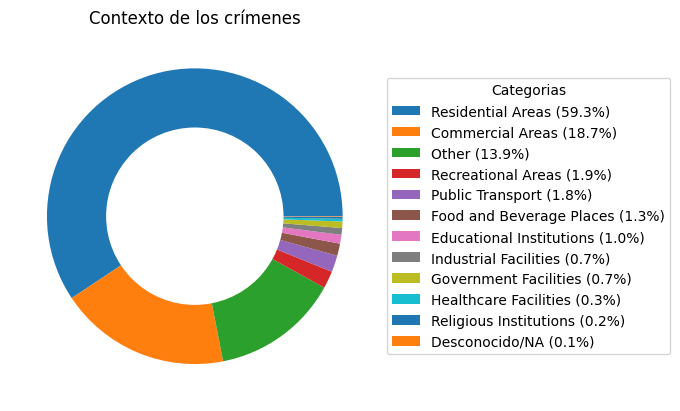

In [282]:
recuento_prop = df["Crime Context"].value_counts()/len(df["Crime Context"])
categorias = [f'{valor} ({recuento_prop.loc[valor]*100:.1f}%)' for valor in recuento_prop.index]
valores = recuento_prop.iloc[0:]

fig, ax = plt.subplots()
ax.pie(valores, labels=None)
centre_circle = plt.Circle((0, 0), 0.60, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax.legend(categorias,
          title="Categorias",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.title("Contexto de los crímenes")
plt.show()

Notamos que la mayoría de crímenes ocurren en áreas residenciales, mientras que los lugares menos comunes de ocurrencia de crímenes en el dataset son instituciones de tipo religiosas o de salud.

Por otro lado, resulta llamativo que para esta variable casi no existen valores faltantes. Pro

### Area Name

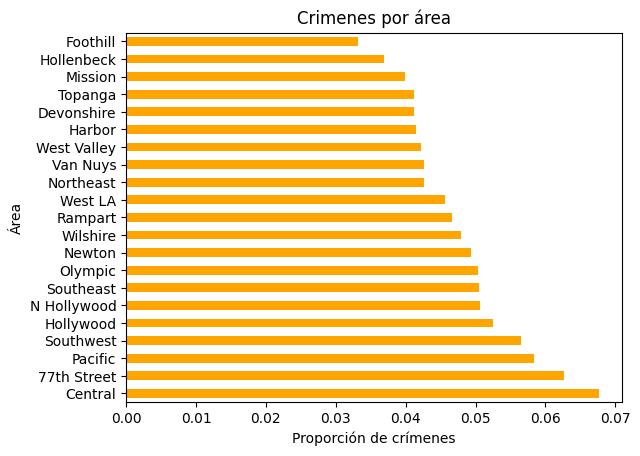

In [283]:
(df["Area Name"].value_counts()/len(df["Area Name"])).plot(kind="barh", color="orange")
plt.title("Crimenes por área")
plt.ylabel("Área")
plt.xlabel("Proporción de crímenes")
plt.show()

El área con mayor cantidad de crímenes, es decir, la moda para esta variable, es el área Central, donde ocurren aproximadamente 7% de los crímenes registrados en el conjunto de datos, el doble que el área con menor ocurrencia de crímenes, Foothill. Por lo demás, no se observan áreas con muchos crímenes o muy pocos, proporcionalmente.

In [284]:
len(df["Area Name"].unique())

21

Vemos que se contemplan 21 áreas distintas para ubicar los crímenes, todas las cuales se pueden observar en el gráfico anterior.

### Vict sex

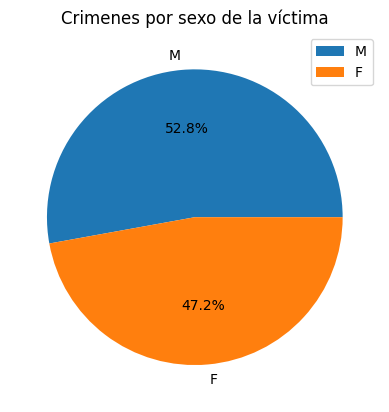

In [285]:
df[(df["Vict Sex"] == "F") | (df["Vict Sex"] == "M")]["Vict Sex"].value_counts().plot(kind="pie", autopct="%1.1f%%")
plt.title("Crimenes por sexo de la víctima")
plt.legend()
plt.ylabel("")
plt.show()

Vemos que la mayoría de crímenes para los cuales se tiene datos sobre el sexo de la víctima son cometidos hacia hombres, aunque la diferencia es menor a 6 puntos porcentuales.

In [286]:
df[df["Vict Sex"] == "Desconocido/NA"]["Vict Sex"].count()/df["Vict Sex"].count()

0.2264610951807062

Sin embargo, es importante resaltar que aproximadamente un 22.6% de los reportes no tienen datos sobre el sexo de la víctima.

### Vict Origin

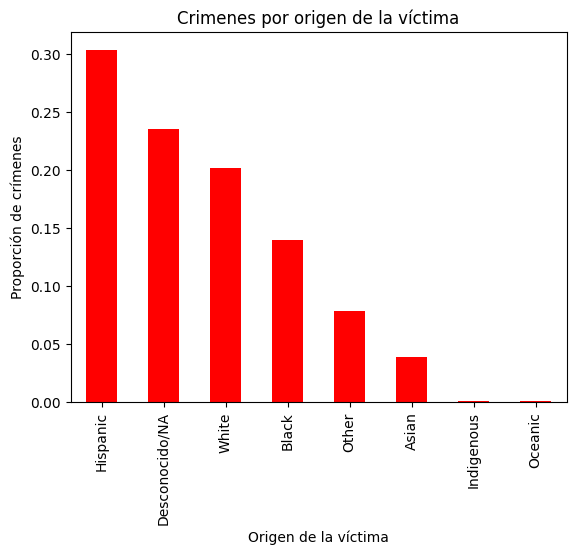

In [287]:
(df["Vict Origin"].value_counts()/len(df["Vict Origin"])).plot(kind="bar", color="Red")
plt.title("Crimenes por origen de la víctima")
plt.ylabel("Proporción de crímenes")
plt.xlabel("Origen de la víctima")
plt.show()

Se observa que aproximadamente uno de cada 3 crímenes tiene como víctima a una persona de origen hispano. Nuevamente, la cantidad de datos faltantes es significativa.

### Investigation Status

In [288]:
df["Investigation Status"].value_counts()/len(df["Investigation Status"])*100

Investigation Status
Invest Cont       79.919165
Adult Other       10.872954
Adult Arrest       8.695337
Juv Arrest         0.327772
Juv Other          0.184239
Desconocido/NA     0.000533
Name: count, dtype: float64

La gran mayoría (~80%) de los crímenes aún están siendo investigados.

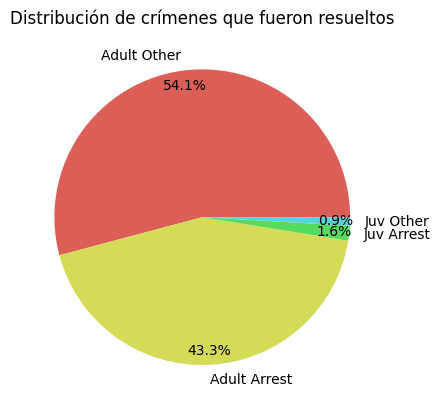

In [289]:
casos_resueltos = df[(df["Investigation Status"] != "Invest Cont") & \
 (df["Investigation Status"] != "Desconocido/NA")]
(casos_resueltos["Investigation Status"].value_counts()/len(casos_resueltos)*100).plot(kind="pie", autopct="%1.1f%%", pctdistance=0.9, colors=sns.color_palette("hls"))
plt.title("Distribución de crímenes que fueron resueltos")
plt.ylabel("")
plt.show()

Por otro lado, se observa que la mayoría de los casos resueltos encuentran como su perpetrador a un adulto.

### Severity

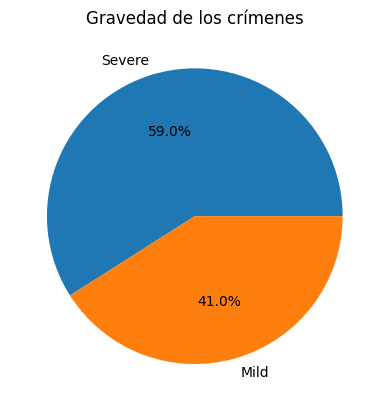

In [290]:
df["Severity"].value_counts().plot(kind="pie", autopct="%1.1f%%")
plt.title("Gravedad de los crímenes")
plt.ylabel("")
plt.show()

Vemos que hay un 50% más de casos graves que leves. Cabe destacar que el grado de severidad tiene que ver con la pena aplicable al delito más que con la opinión subjetiva que le merezca al observador dicho delito.

## Variables cuantitativas

### Vict Age

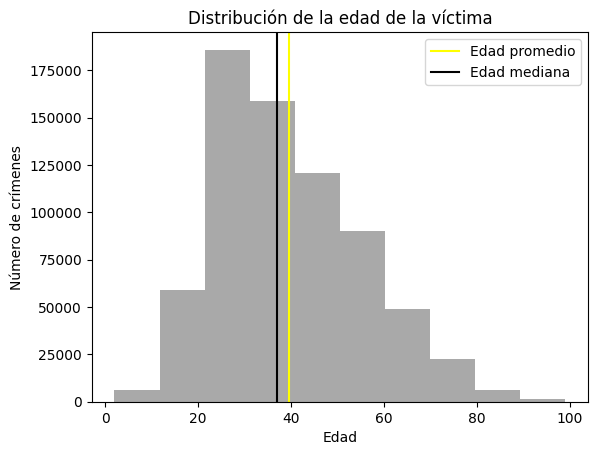

In [291]:
fig, ax = plt.subplots()
ax.hist(df["Vict Age"], color="darkgrey")
plt.title("Distribución de la edad de la víctima")
plt.xlabel("Edad")
plt.axvline(x=df["Vict Age"].mean(), color="yellow", label="Edad promedio")
plt.axvline(x=df["Vict Age"].median(), color="Black", label="Edad mediana")
legend = ax.legend()
plt.ylabel("Número de crímenes")
plt.show()

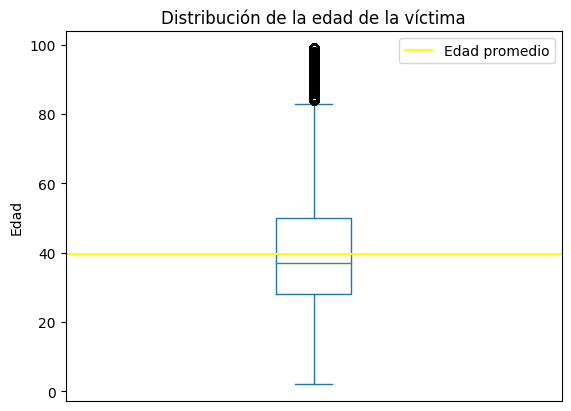

In [292]:
#fig, ax = plt.subplots()
# Hacemos un boxplot de la variable edad
df["Vict Age"].plot(kind="box")
plt.title("Distribución de la edad de la víctima")
plt.xticks([])
plt.axhline(y=df["Vict Age"].mean(), color="yellow", label="Edad promedio")
#legend = ax.legend()
plt.legend()

plt.ylabel("Edad")
plt.show()

Vemos que la variable edad tiene una ligera asimetría a la derecha, aunque casi existe una coincidencia entre la media y la mediana. Las personas con edad mayor a los 80 años son consideradas outliers para esta distribución.

Analicemos los cuartiles:

In [293]:
descripcion = df["Vict Age"].describe()
print(descripcion)
print("\nEl rango intercuartílico es de", descripcion.loc["75%"]-descripcion.loc["25%"], \
      "mientras que el rango de la variable es de", descripcion.loc["max"]-descripcion.loc["min"])

count    700171.000000
mean         39.566777
std          15.615966
min           2.000000
25%          28.000000
50%          37.000000
75%          50.000000
max          99.000000
Name: Vict Age, dtype: float64

El rango intercuartílico es de 22.0 mientras que el rango de la variable es de 97.0


In [294]:
# Calculamos el coeficiente de variación
print("El coeficiente de variación de la edad es de", descripcion.loc["std"]/descripcion.loc["mean"])

El coeficiente de variación de la edad es de 0.3946736913073199


Podemos con estos datos afirmar que la edad tiene una alta dispersión, pero su distribución es relativamente simétrica.

## Tiempo

### Por año

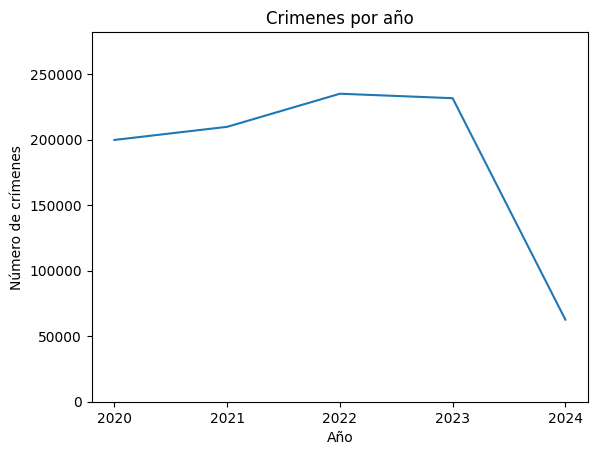

In [295]:
crimenes_por_año = df["Date Occ"].dt.year.value_counts()
crimenes_por_año.sort_index().plot(kind="line")

#Get the current axis of the plot
ax = plt.gca()

#Set major locator to MaxNLocator with integer argument to ensure only integers (years) are shown
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title("Crimenes por año")
plt.ylim(0, crimenes_por_año.max()*1.2)
plt.xlabel("Año")
plt.ylabel("Número de crímenes")
plt.show()

La cantidad de crímenes reportados alcanza su máximo en el año 2022, mientras que la cantidad para el año 2024 se reduce drásticamente, lo cual se debe principalmente a que el año aún no ha terminado. Para el resto de los años, se observa una leve tendencia creciente.

### Por mes

En este caso, no consideraremos los datos para 2024 debido a que solo contiene datos para los primeros meses del año.

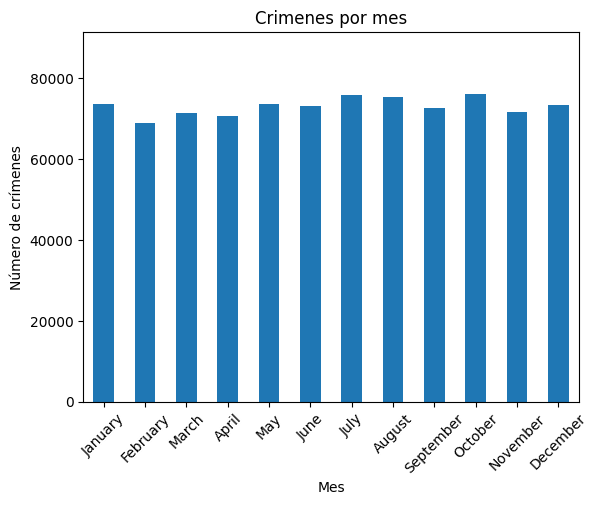

In [296]:
df_sin_2024 = df[df["Date Occ"].dt.year != 2024]
crimenes_por_mes = df_sin_2024["Date Occ"].dt.month.value_counts()
crimenes_por_mes = crimenes_por_mes.sort_index()
crimenes_por_mes.index =  crimenes_por_mes.index.map(lambda x: calendar.month_name[x])
crimenes_por_mes.plot(kind="bar")
plt.xticks(rotation=45)
plt.title("Crimenes por mes")
plt.ylim(0, crimenes_por_mes.max()*1.2)
plt.xlabel("Mes")
plt.ylabel("Número de crímenes")
plt.show()

En base al gráfico, no parece haber ninguna tendencia particular relacionando al mes con la cantidad de crímenes,al menos en el agregado de todos los años.

### Por día de la semana

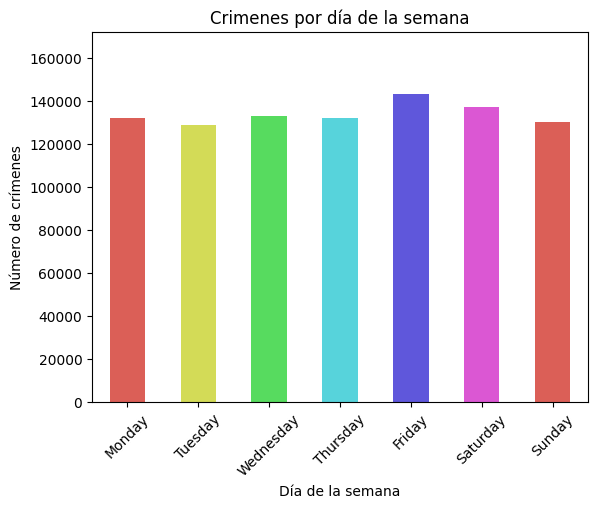

In [297]:
crimenes_por_dia = df["Date Occ"].dt.weekday.value_counts()
crimenes_por_dia = crimenes_por_dia.sort_index()
crimenes_por_dia.index =  crimenes_por_dia.index.map(lambda x: calendar.day_name[x])
crimenes_por_dia.plot(kind="bar", color=sns.color_palette("hls"))
plt.xticks(rotation=45)
plt.title("Crimenes por día de la semana")
plt.ylim(0, crimenes_por_dia.max()*1.2)
plt.xlabel("Día de la semana")
plt.ylabel("Número de crímenes")
plt.show()

Nuevamente, a simple vista, no se observa ningún tipo de correlación entre el día de la semana y la cantidad de ocurrencias de crímenes.

### Por hora

In [298]:
df["Time Occ"].head(10)

0    21
1    18
2    17
3    20
4    12
5    23
6     9
7    11
8    14
9    12
Name: Time Occ, dtype: int64

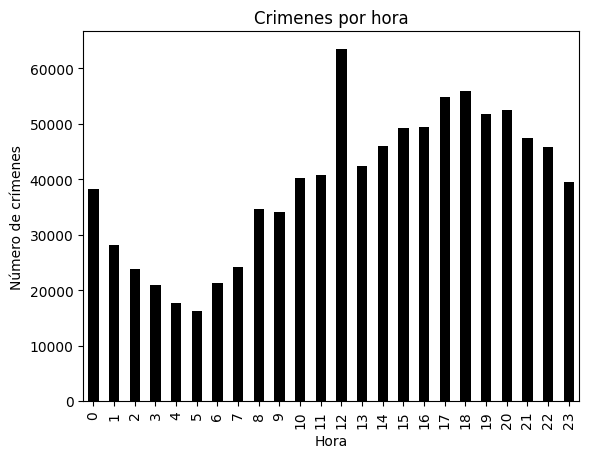

In [299]:
df['Time Occ'].value_counts().sort_index().plot(kind="bar", color="black")
plt.title("Crimenes por hora")
plt.xlabel("Hora")
plt.ylabel("Número de crímenes")
plt.show()

Se puede observar que la cantidad de crímenes toma su mínimo a las 5 de la madrugada, y va creciendo hasta alcanzar un pico a las 18 de la tarde, sumado a una cantidad desproporcionada de hechos registrados a las 12 del mediodía. Esto, viendo la tendencia general de los datos, y el desplome que ocurre en la hora siguiente, probablemente se deba a algunas particularidades de la forma en que se registran o reportan los crímenes. Por ejemplo, una víctima podría decir "el crimen ocurrió al mediodía", de manera que se registre a las 12 en punto, acaparando así a todos los crímenes que suceden en ese rango horario.


In [300]:
df['Time Occ'].describe()

count    938457.000000
mean         13.200763
std           6.524246
min           0.000000
25%           9.000000
50%          14.000000
75%          19.000000
max          23.000000
Name: Time Occ, dtype: float64

# Análisis bivariado

## Gravedad por sexo

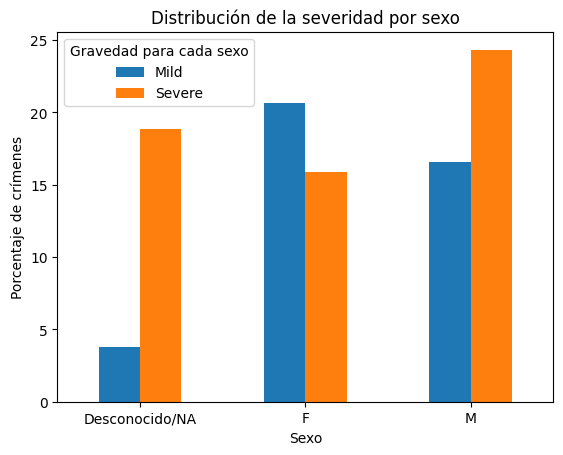

In [301]:
(((df.groupby(["Vict Sex", "Severity"]).Severity.count())/len(df))*100).unstack().plot(kind="bar")
plt.title("Distribución de la severidad por sexo")
plt.xlabel("Sexo")
plt.ylabel("Porcentaje de crímenes")
plt.legend(title="Gravedad para cada sexo")
plt.xticks(rotation=0)
plt.show()

### Crímenes más comunes hacia cada sexo

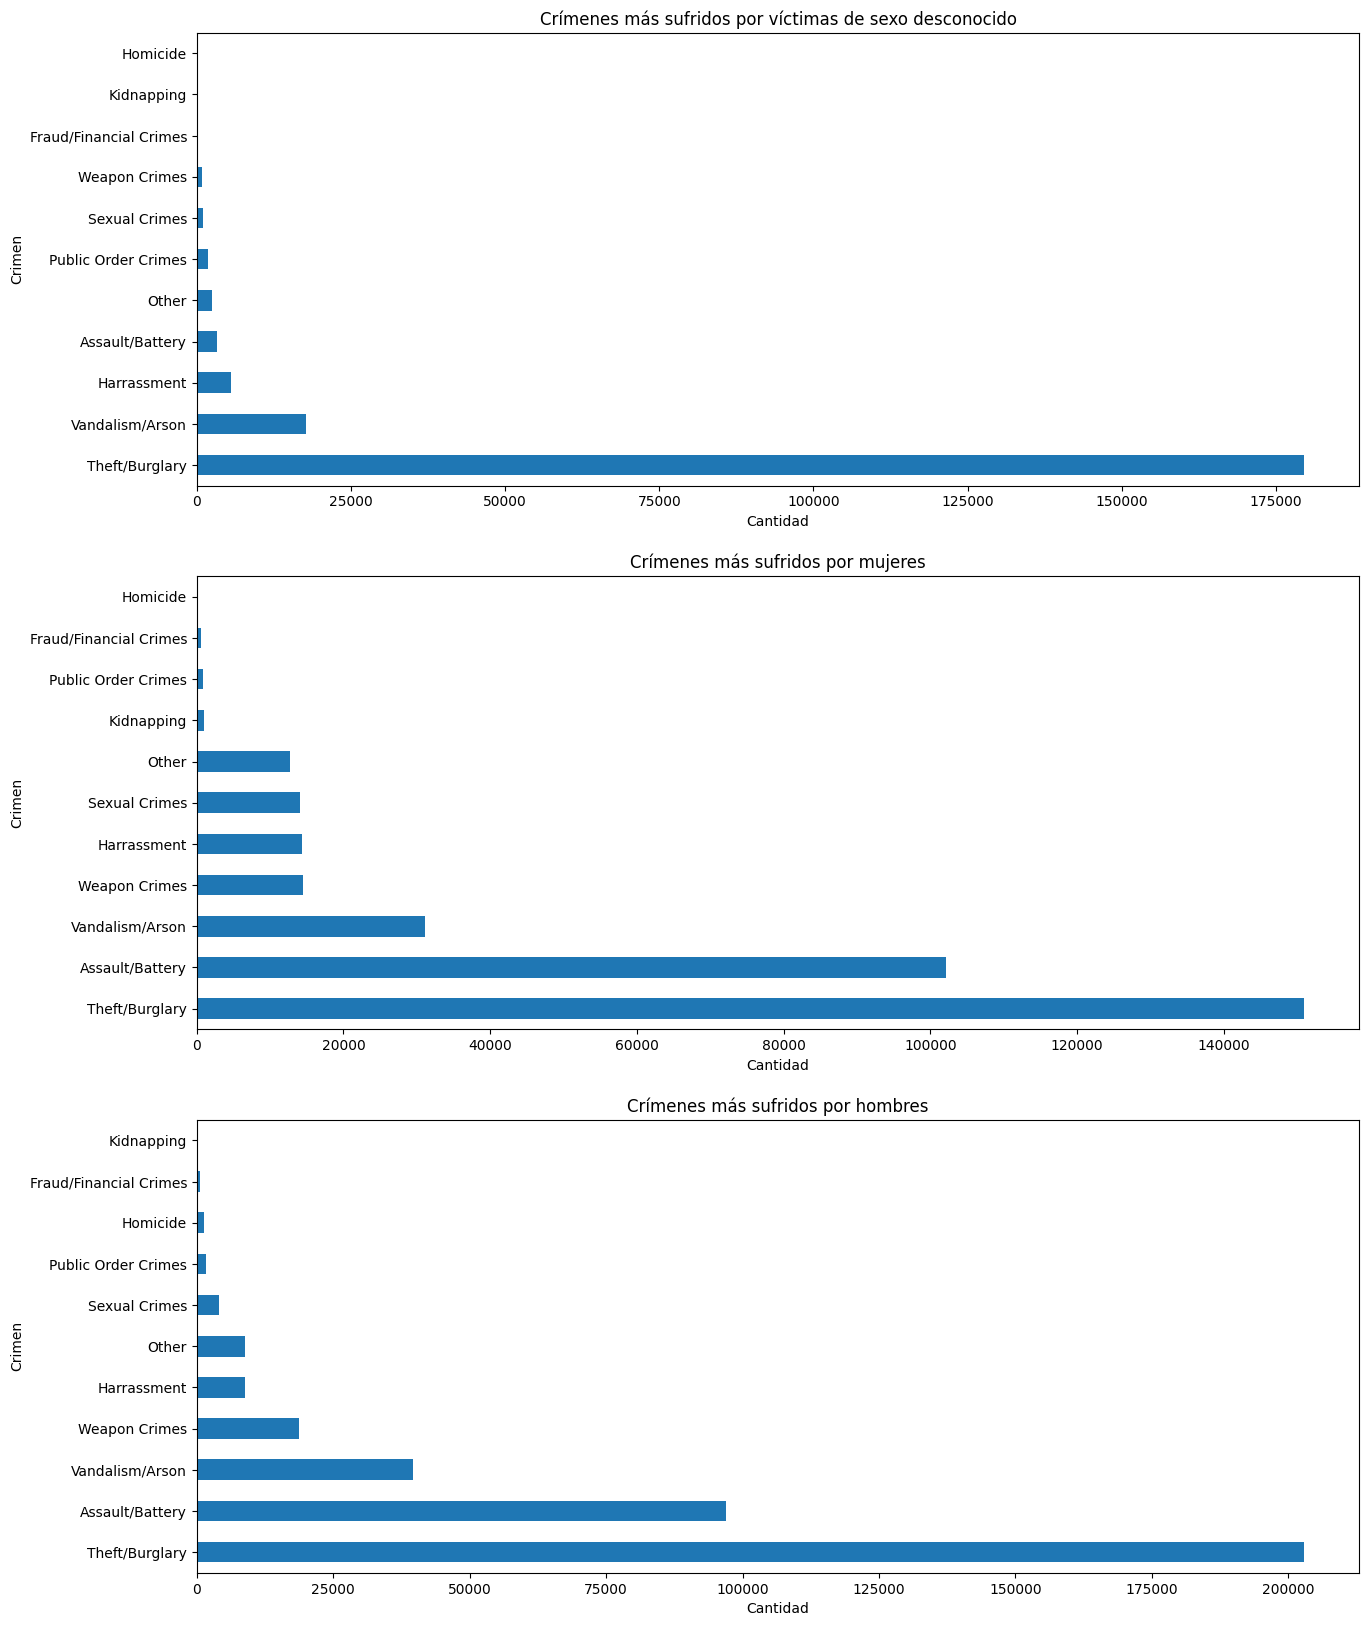

In [302]:
fig, axes = plt.subplots(3, 1, figsize=(15, 20))
plt.title("Crímenes más sufridos por cada sexo")

df[df["Vict Sex"] == "Desconocido/NA"]["Crime"].value_counts().plot(kind="barh", ax=axes[0])
axes[0].set_title("Crímenes más sufridos por víctimas de sexo desconocido")
axes[0].set_ylabel("Crimen")
axes[0].set_xlabel("Cantidad")

df[df["Vict Sex"] == "F"]["Crime"].value_counts().plot(kind="barh", ax=axes[1])
axes[1].set_title("Crímenes más sufridos por mujeres")
axes[1].set_ylabel("Crimen")
axes[1].set_xlabel("Cantidad")

df[df["Vict Sex"] == "M"]["Crime"].value_counts().plot(kind="barh", ax=axes[2])
axes[2].set_title("Crímenes más sufridos por hombres")
axes[2].set_ylabel("Crimen")
axes[2].set_xlabel("Cantidad")

plt.show()

In [303]:
df[df["Crime"] == "Homicide"]["Vict Sex"].value_counts()/len(df[df["Crime"] == "Homicide"]["Vict Sex"]) *100

Vict Sex
M                 86.127168
F                 13.615928
Desconocido/NA     0.256904
Name: count, dtype: float64

In [304]:
df[df["Crime"] == "Theft/Burglary"]["Vict Sex"].value_counts()/len(df[df["Crime"] == "Theft/Burglary"]["Vict Sex"])*100

Vict Sex
M                 38.034782
Desconocido/NA    33.664089
F                 28.301130
Name: count, dtype: float64

En base a estos gráficos, sospechamos que existen algunos tipos de crímenes que no registran a nadie como víctima, como por ejemplo el vandalismo y los incendios intencionados, además de algunos tipos específicos de robos, y que suelen estar clasificados como severos.
En efecto, un análisis de los homicidios muestra que en el 99.7 % de los casos se registra el sexo de la víctima, mientras que esta proporción es de 66.3% para los robos.


Por otro lado, vemos que los crímenes que más se cometen contra hombres se asemejan en buena medida de los crímenes que más sufren las mujeres en el dataset, al menos en las principales categorías. Sin embargo, los hombres son más propensos a ser víctimas de crímenes clasificados como severos.

## Gravedad por origen

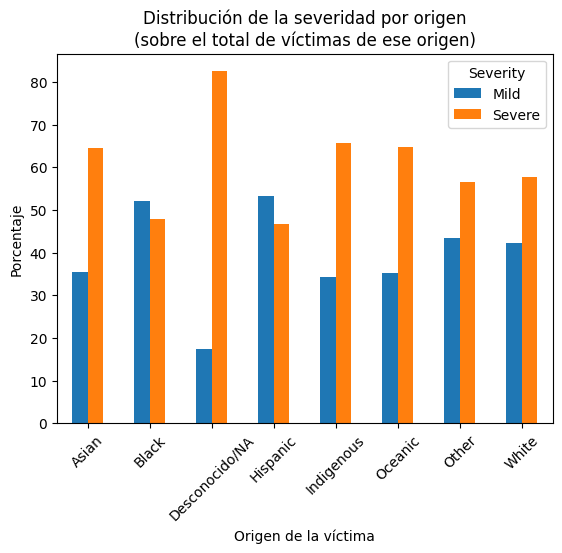

In [305]:
grupos = df.groupby(["Vict Origin", "Severity"])
ax = ((grupos.Severity.count()/grupos.size().groupby(level="Vict Origin").sum())*100).unstack().plot(kind="bar")
ax.set_title("Distribución de la severidad por origen\n(sobre el total de víctimas de ese origen)")
plt.xlabel("Origen de la víctima")
plt.ylabel("Porcentaje")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

Se puede ver que la proporción de crímenes graves varía mucho dependiendo del origen de la víctima, por ejemplo, aquellas personas de origen indígena tienen el doble de probabilidades de sufrir un crímen severo que uno leve. Mientras que los de origen hispano o negro tienen probabilidades marginalmente superiores de sufrir un crimen leve.
Con respecto a los de origen desconocido, parece que ocurre el mismo fenómeno observado con el sexo de la víctima.

## Edad y crimen

<Figure size 2000x1200 with 0 Axes>

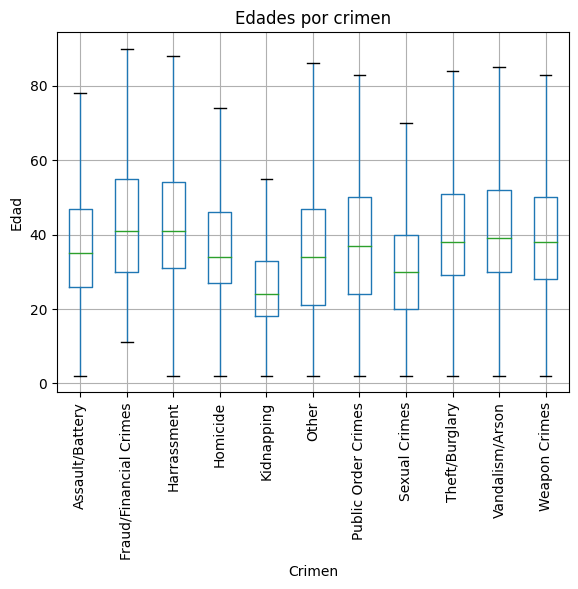

In [306]:
plt.figure(figsize=(20, 12))
df2 = df[["Crime", "Vict Age"]]
bp = df2.boxplot(by="Crime", showfliers=False)
bp.get_figure().suptitle('')
plt.title("Edades por crimen")
plt.xlabel("Crimen")
plt.xticks(rotation=90)
plt.ylabel("Edad")
plt.show()

In [307]:
df2[df["Crime"] == "Fraud/Financial Crimes"]["Vict Age"].min()

11.0

Vemos que todas las categorías de contexto presentan una alta dispersión respecto de la edad de la víctima. Algunas categorías que resaltan por su clara tendencia son los secuestros y los crímenes sexuales, que son las categorías que tienen menores medianas y menores primeros cuartiles. Secuestro además es la de menor rango intercuartílico, todas estas características indican que, de ocurrir uno de estos crímenes, será mayor la probabilidad de que la víctima sea una persona joven.

En el extremo opuesto, los crímenes financieros y el fraude tienen como víctima generalmente a personas de mayor edad, con una mediana de aproximada 40 años.
Además es la única categoría para la cual no existe ninguna víctima menor a 11 años. Esto es razonable, ya que los menores tienen menor acceso al dinero, y por tanto, menos posibildades de caer víctimas de fraudes, y también podría indicar que las personas de edad mayor son potencialmente más susceptibles a ser manipulados.

## Edad y contexto

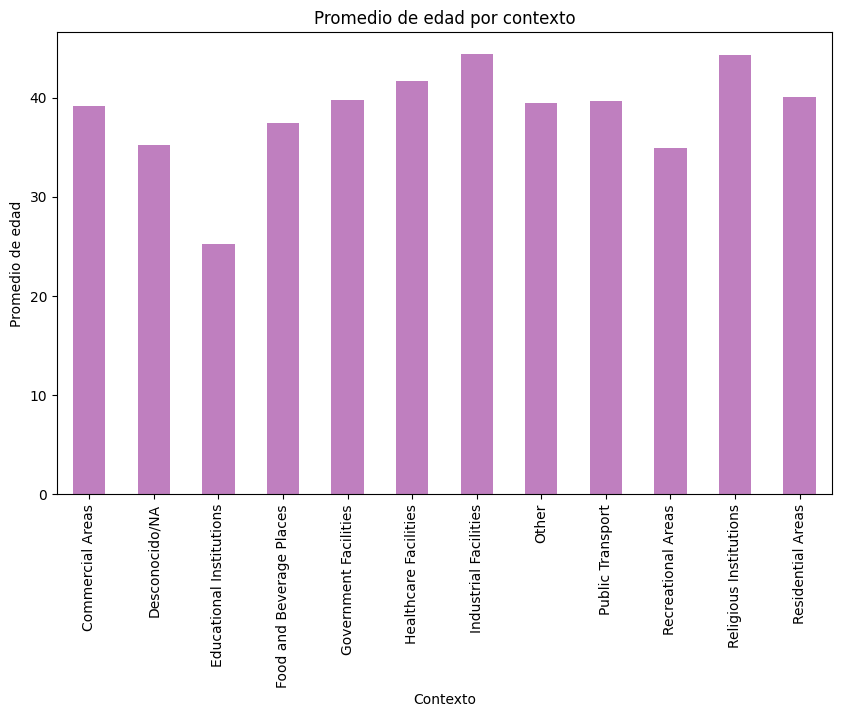

In [308]:
# Graficamos un barplot que muestra el promedio de edad en cada contexto
plt.figure(figsize=(10, 6))
df.groupby("Crime Context")["Vict Age"].mean().plot(kind="bar", color="purple", alpha=0.5)
plt.title("Promedio de edad por contexto")
plt.xlabel("Contexto")
plt.ylabel("Promedio de edad")
plt.show()


En general se nota que la mayoría de crímenes, la edad de la víctima en casi todos los contextos es relativamente similar al promedio general del dataset, de 39.5.

Sin embargo, existe una clara excepción a este fenómeno: como es de esperar, las víctimas de crímenes que suceden en contextos de instituciones educacionales tienen edad en promedio aproximadamente 15 años por debajo de la media general.

Es importante considerar que este análisis está sujeto a la manera en que decidimos agrupar las categorías para simplificar su análisis.

## Severidad por área

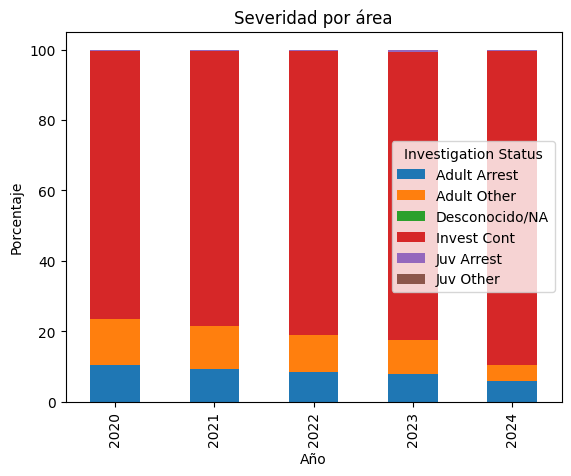

In [309]:
df2 = df.copy()
df2["Year"] = df2["Date Occ"].dt.year
severity_counts = df2.groupby(['Year', 'Investigation Status']).size().unstack(fill_value=0)
total_counts = severity_counts.sum(axis=1)
severity_proportions = severity_counts.div(total_counts, axis=0) * 100
ax = severity_proportions.plot(kind='bar', stacked=True)
ax.set_title("Severidad por área")
ax.set_xlabel("Año")
ax.set_ylabel("Porcentaje")
plt.show()

Vemos que a medida que más tiempo pasa de la comisión de un crimen, las probabildiades de que su investigación haya concluído, como es de esperar, incrementan.

# Análisis geográfico

In [310]:
# No nos interesan datos para los cuales no tenemos la ubicación a partir de ahora
df = df[~df["LAT"].isna()]
df = df[~df["LON"].isna()]
len(df)

936193

In [311]:
# Pasamos a un dataframe de tipo geográfico a partir de ahora
df['geometry'] = df.apply(lambda row: Point(row['LON'], row['LAT']), axis=1)
df = df.drop(columns= ['LAT', 'LON'])
gdf = gpd.GeoDataFrame(df, geometry='geometry')

## Cantidad de crímenes por barrio

Obtuvimos un dataset de cada uno de los barrios de Los Ángeles aquí
- https://geohub.lacity.org/datasets/9c8639737e3a457a8c0f6a93f9c36974_18/explore

en un formato que pudiera ser analizado por geopandas, geojson. A partir de esta información, y dado que conocemos la ubicación de cada uno de los crímenes reportados, veremos cómo se distribuyen entre los distintos barrios.

In [312]:
df_barrios = gpd.read_file("/content/Neighborhood_Councils_(Certified).geojson")
# Nombre del barrio, Polígono que lo representa
df_barrios = df_barrios[["NAME", "geometry"]]
df_barrios.head()

NAME  \
0                      ARLETA NC   
1                 ARROYO SECO NC   
2  ARTS DISTRICT LITTLE TOKYO NC   
3             ATWATER VILLAGE NC   
4       BEL AIR-BEVERLY CREST NC   

                                            geometry  
0  POLYGON ((-118.44305 34.26328, -118.44317 34.2...  
1  POLYGON ((-118.19567 34.08613, -118.19567 34.0...  
2  POLYGON ((-118.23151 34.05348, -118.23152 34.0...  
3  POLYGON ((-118.25279 34.10833, -118.24958 34.1...  
4  POLYGON ((-118.36574 34.09948, -118.36573 34.0...

Obtenemos la cantidad de crímenes ocurridos en cada barrio

In [313]:
for i in range(0, len(df_barrios["geometry"])):
  df_barrios.loc[i, "Num Crimes"] = gdf["geometry"].within(df_barrios.loc[i, "geometry"]).sum()

In [314]:
max = df_barrios["Num Crimes"].max()
m = folium.Map(location=[34, -118.28823], zoom_start=10)
folium.TileLayer('OpenStreetMap').add_to(m) #podemos cambiar de Tile
c = folium.Choropleth(
 geo_data=df_barrios,
 name="choropleth",
 data=df_barrios,
 columns= ["NAME","Num Crimes"],
 key_on="feature.properties.NAME",
 fill_color="RdYlGn_r",
 fill_opacity=0.8,
 threshold_scale = [0, 0.1*max, 0.2*max, 0.3*max, 0.4*max, 0.6*max, 0.80*max, max],
 line_opacity=1,
 legend_name="Número de crímenes")

c.geojson.add_child(folium.features.GeoJsonTooltip(['Num Crimes']))
c.add_to(m)
m

Utilizamos un gradiente de color con intervalos no uniformes para poder visualizar mejor los números de crímenes ya que existen algunos barrios con valores extremos, mientras que la mayoría se ubica muy por debajo y presenta magnitudes similares.

Vemos que existen barrios donde hay una notable diferencia en la cantidad de crímenes ocurridos. Se observan múltiples casos donde la cantidad de crímenes reportados en barrios adyacentes varía de manera sustancial. Esto podría información podría resultar importante para guiar los esfuerzos de las fuerzas de seguridad de la ciudad de los Ángeles en la lucha contra el crimen.

## Homicidios en el mapa

In [315]:
len(gdf[gdf["Crime"] == "Homicide"])

1555

Vemos que es una cantidad razonable de datos para poder ser graficados, y resultan de mucho interés estudiar este tipo de crímenes a través del espacio.

In [316]:
gdf["Date Occ"] = gdf["Date Occ"].astype("str")

m = folium.Map(location=[34, -118.28823], zoom_start=10)

male_fg = folium.FeatureGroup(name='Male (M)')
female_fg = folium.FeatureGroup(name='Female (F)')
unk_fg = folium.FeatureGroup(name='Desconocido')


for _, row in gdf[(gdf["Crime"] == "Homicide") & (gdf["Vict Sex"] == "F")].iterrows():
    folium.CircleMarker(
        location=[(row['geometry'].coords[0][1]), (row['geometry'].coords[0][0])],
        popup=row['Date Occ'],
        color='blue',
        fill_color='blue',
        radius=1
    ).add_to(female_fg)

for _, row in gdf[(gdf["Crime"] == "Homicide") & (gdf["Vict Sex"] == "M")].iterrows():
    folium.CircleMarker(
        location=[(row['geometry'].coords[0][1]), (row['geometry'].coords[0][0])],
        popup=row['Date Occ'],
        color='red',
        fill_color='red',
        radius=1
    ).add_to(male_fg)


for _, row in gdf[(gdf["Crime"] == "Homicide") & (gdf["Vict Sex"] == "Desconocido/NA")].iterrows():
    folium.CircleMarker(
        location=[(row['geometry'].coords[0][1]), (row['geometry'].coords[0][0])],
        popup=row['Date Occ'],
        color='green',
        fill_color='green',
        radius=1
    ).add_to(unk_fg)


unk_fg.add_to(m)
male_fg.add_to(m)
female_fg.add_to(m)


legend_html = """
<div style="position: fixed; bottom: 50px; left: 50px; background-color: white;
             border: 2px solid gray; z-index: 1000; padding: 10px;">
    <p><strong>Legend</strong></p>
    <p><span style="color: green;">&#9679;</span> Desconocido/NA</p>
    <p><span style="color: blue;">&#9679;</span> Female (F)</p>
    <p><span style="color: red;">&#9679;</span> Male (M)</p>
</div>
"""
legend = FloatImage(legend_html, bottom=50, left=50).add_to(m)

folium.LayerControl().add_to(m)
m

Se pueden observar los homicidios discriminados por género según el color. Además clickeando sobre un punto, se puede obtener la fecha de su ocurrencia.